# MRI Brain Tumor Classification

In [1]:
import numpy as np
import pandas as pd
import glob
import os
import cv2
import time
import random
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tempfile import TemporaryDirectory
from sklearn.metrics import confusion_matrix, accuracy_score
from torchvision import models, transforms, datasets
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset, DataLoader, ConcatDataset, random_split
from torch.optim import lr_scheduler

## Variables

In [2]:
#Directory path
root_path = '/kaggle/input/brain-tumor-mri-dataset'

#Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device} device")

#Recommended mean and std
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

#Variables
batch_size = 16
learning_rate = 0.001
num_epochs = 16

Using cuda device


## Data Transform

In [3]:
#Set Transform
data_transforms = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
])

## Data Loader

In [4]:
#Load images
image_ds = {x: datasets.ImageFolder(os.path.join(root_path, x), data_transforms) for x in ['Training', 'Testing']}

#Set dataloader
dataloaders = {x: torch.utils.data.DataLoader(image_ds[x], batch_size=batch_size, shuffle=True) for x in ['Training', 'Testing']}

#Check dataset sizes and classes
dataset_sizes = {x: len(image_ds[x]) for x in ['Training', 'Testing']}
class_names = image_ds['Training'].classes

print(f'names of classes: {class_names}')

names of classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


## Visualizing Images

In [5]:
#Plot images
def plotimg(num = 4):
    imgs = {}
    for label in class_names:
        imgs[label] = []
        for img_path in glob.iglob(root_path + '/Training/' + label + '/*'):
            img = cv2.imread(img_path) #get an image            
            img = cv2.resize(img, (128, 128)) #resize it
            b, g, r = cv2.split(img) #get the BGR values
            cv2.merge([r, g, b])
            imgs[label].append(img)
            
    for label in imgs:
        plt.figure(figsize = (16, 9))
        for i in range(num):
            plt.subplot(1, num, i + 1)
            plt.title(label)
            plt.imshow(imgs[label][random.randrange(len(imgs[label]))])


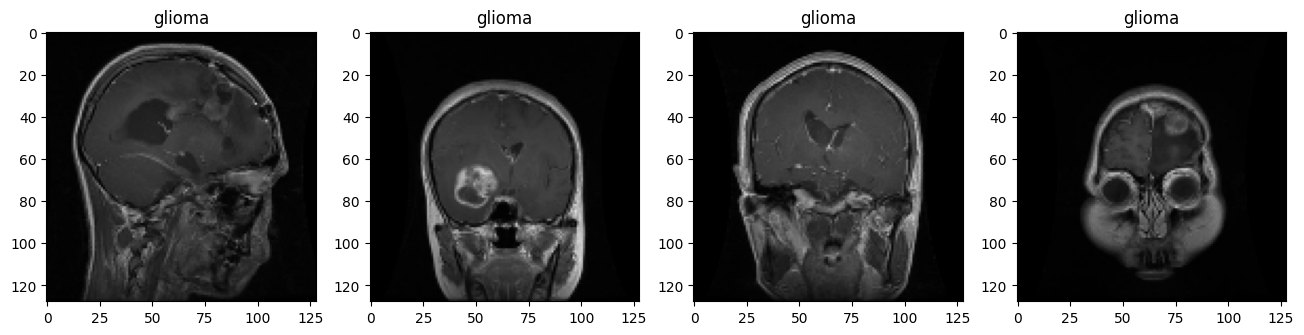

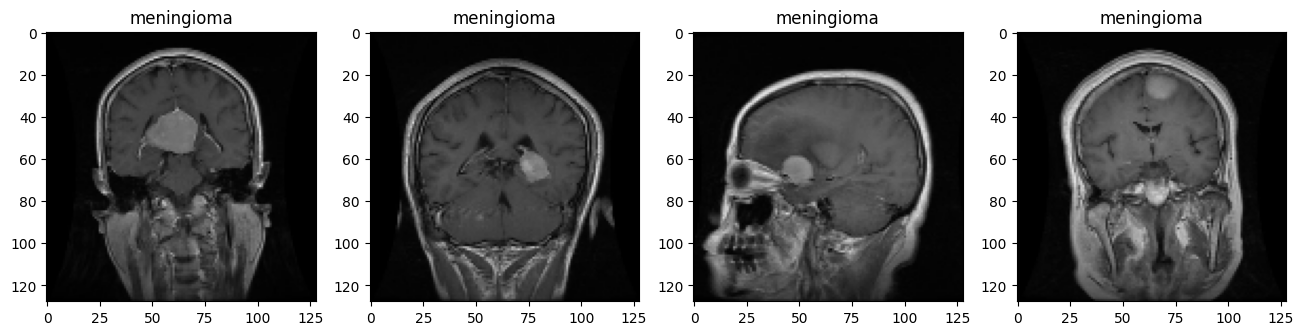

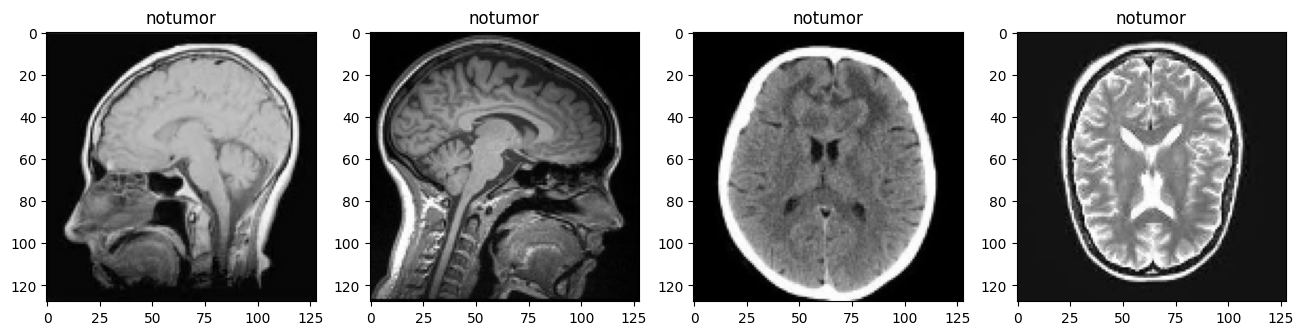

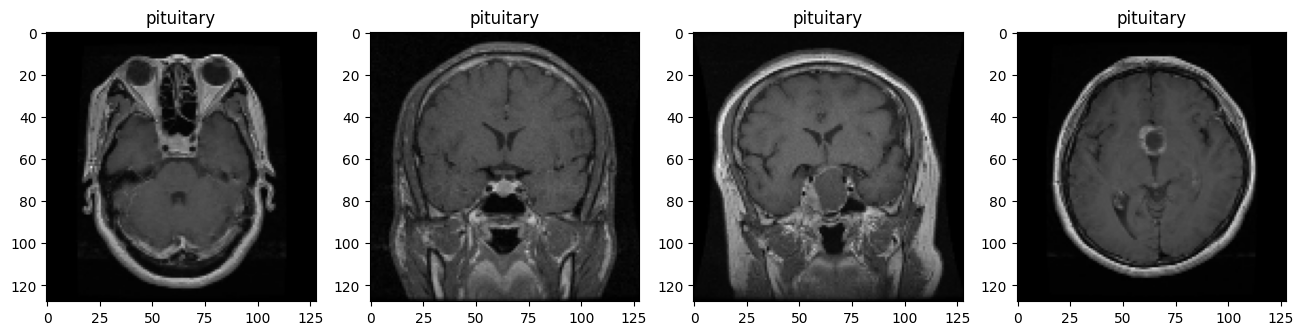

In [6]:
plotimg()

## Transfer Learning

In [7]:
def tranfer_learning(model_name):
    if model_name == 'resnet18':
        model = models.resnet18()
        num_ft = model.fc.in_features
        model.fc = nn.Linear(num_ft, 4)
        model = model.to(device)
        return model
    elif model_name == 'densenet121':
        model = models.densenet121()
        num_ft = model.classifier.in_features
        model.classifier = nn.Linear(num_ft, 4)
        model = model.to(device)
        return model
    elif model_name == 'efficientnet_v2_s':
        model = models.efficientnet_v2_s()
        num_ft = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_ft, 4)
        model = model.to(device)
        return model
    else:
        print("I don't know that model")

In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    history = {}
    history['Testing'] = []
    history['Training'] = []
    
    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and testing phase
            for phase in ['Training', 'Testing']:
                if phase == 'Training':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'Training'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'Training':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    
                if phase == 'Training':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.to(torch.float) / dataset_sizes[phase]
                history[phase].append([epoch_loss, epoch_acc])
                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
                
                # deep copy the model
                if phase == 'Testing' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))

    return model, history

In [9]:
transfer_models = ['resnet18', 'densenet121', 'efficientnet_v2_s']
history = {}
for transfer_model in transfer_models:
    model = tranfer_learning(transfer_model)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    model, history[transfer_model] = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=16)

Epoch 0/15
----------
Training Loss: 0.7660 Acc: 0.7054
Testing Loss: 0.6402 Acc: 0.7330

Epoch 1/15
----------
Training Loss: 0.5207 Acc: 0.7967
Testing Loss: 0.5371 Acc: 0.7887

Epoch 2/15
----------
Training Loss: 0.4158 Acc: 0.8466
Testing Loss: 0.3853 Acc: 0.8566

Epoch 3/15
----------
Training Loss: 0.3435 Acc: 0.8731
Testing Loss: 0.4652 Acc: 0.8337

Epoch 4/15
----------
Training Loss: 0.2839 Acc: 0.8978
Testing Loss: 0.3963 Acc: 0.8436

Epoch 5/15
----------
Training Loss: 0.2295 Acc: 0.9167
Testing Loss: 0.2054 Acc: 0.9252

Epoch 6/15
----------
Training Loss: 0.1667 Acc: 0.9442
Testing Loss: 0.4538 Acc: 0.8825

Epoch 7/15
----------
Training Loss: 0.0918 Acc: 0.9685
Testing Loss: 0.0897 Acc: 0.9657

Epoch 8/15
----------
Training Loss: 0.0571 Acc: 0.9820
Testing Loss: 0.0732 Acc: 0.9710

Epoch 9/15
----------
Training Loss: 0.0469 Acc: 0.9853
Testing Loss: 0.0603 Acc: 0.9809

Epoch 10/15
----------
Training Loss: 0.0479 Acc: 0.9853
Testing Loss: 0.0700 Acc: 0.9703

Epoch 11/

# Plot History

In [10]:
def plot_history(history, transfer_model):
    train_loss = [item[0] for item in history['Training']]
    train_acc = [item[1].cpu().numpy() for item in history['Training']]
    
    test_loss = [item[0] for item in history['Testing']]
    test_acc = [item[1].cpu().numpy() for item in history['Testing']]
    
    epochs = range(1, len(train_loss) + 1)
    
    # Plotting
    plt.figure(figsize=(14, 6))
    plt.title(history)
    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'bo-', label='train Loss')
    plt.plot(epochs, test_loss, 'ro-', label='val Loss')
    plt.title('Train & Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()
    
    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, 'bo-', label='train Accuracy')
    plt.plot(epochs, test_acc, 'ro-', label='val Accuracy')
    plt.title('Train & Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()
    
    plt.suptitle(transfer_model, fontsize=16, fontweight='bold')

    plt.tight_layout()
    plt.show()


<ipython-input-10-1c1279a8941a>:14: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


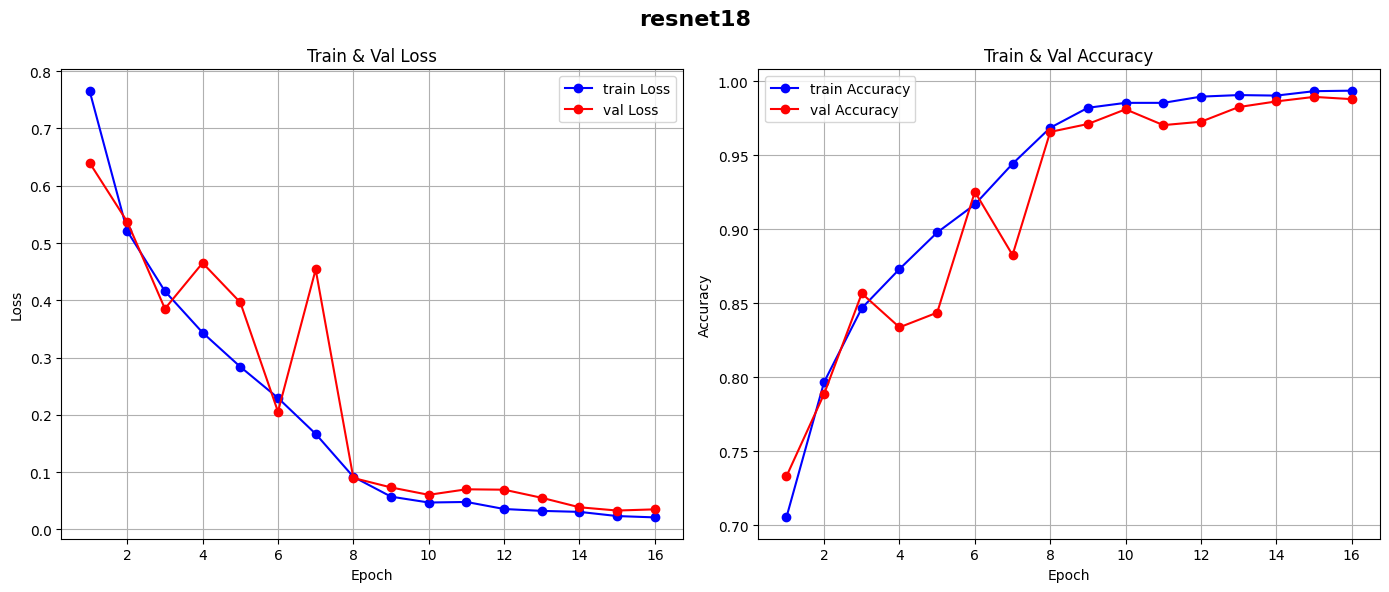

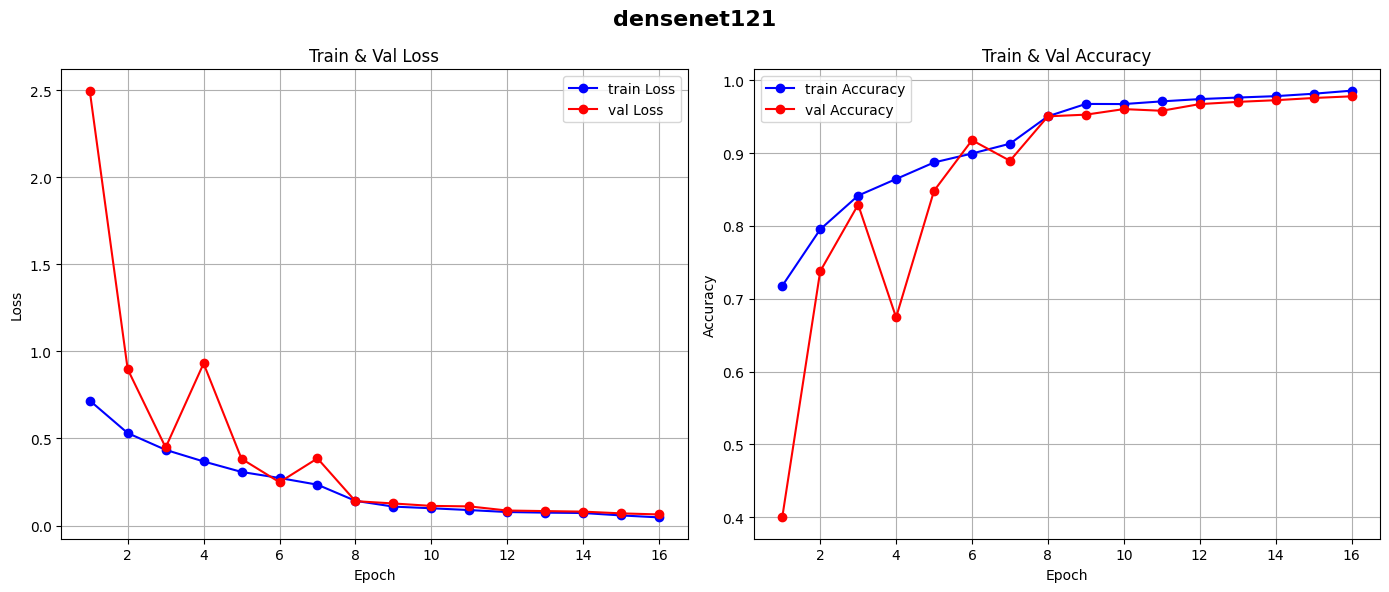

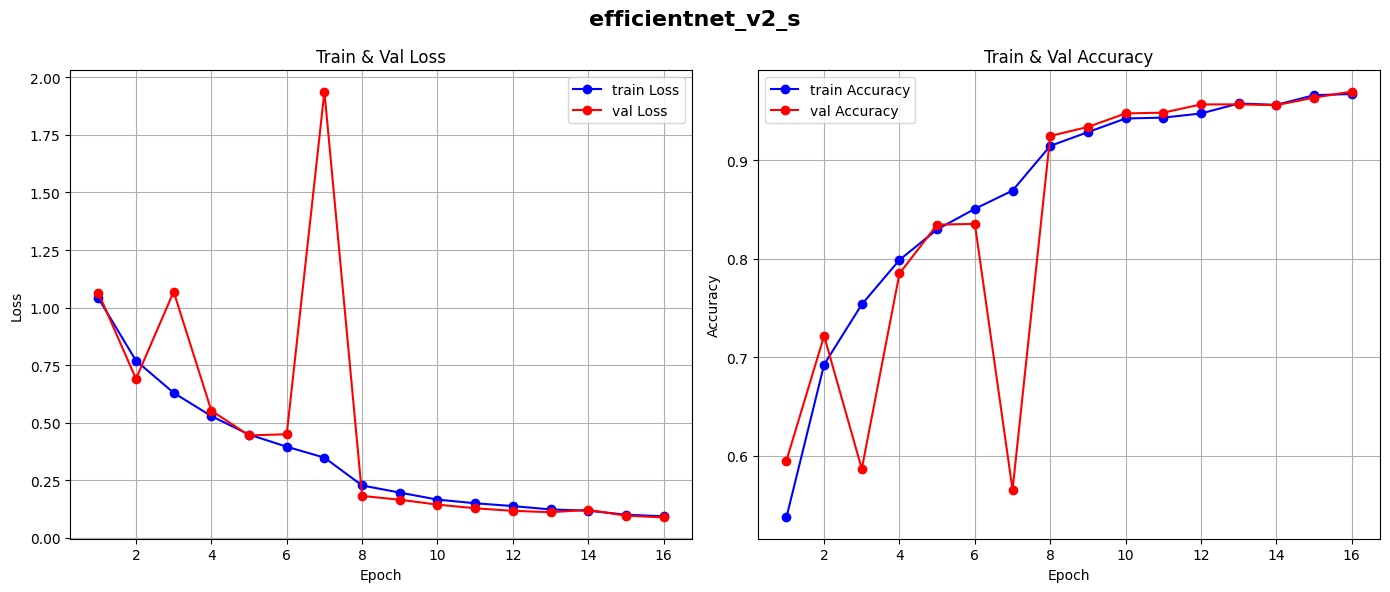

In [11]:
for transfer_model in transfer_models:
    plot_history(history[transfer_model], transfer_model)